In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

INPUT_CSV = "/path/to/file" # Place path to either inner or full histogram here
PHASE_FILTER = "attack" 
CHUNK_SIZE = 100_000 # Change based on memory constraints and histogram file size
MIN_PX_AT_OR_ABOVE = 10

hist_cols = [f"d{i}" for i in range(193)]
bins = np.arange(193, dtype=np.int16)

base_cols = ["phase", "discrepency", "granularity", "frequency"]
usecols = base_cols + hist_cols

def weighted_median_from_counts(values_2d, counts_2d):
    """
    values_2d: (N, M) integer values (e.g., deltas)
    counts_2d: (N, M) nonnegative counts
    Returns median value per row (float), NaN if row has 0 total weight.
    """
    w = counts_2d
    tot = w.sum(axis=1)
    out = np.full(w.shape[0], np.nan, dtype=np.float32)
    ok = tot > 0
    if not np.any(ok):
        return out
    c = np.cumsum(w[ok], axis=1)              # [web:75]
    half = (tot[ok] / 2.0).astype(np.float32)
    idx = np.argmax(c >= half[:, None], axis=1)
    out[ok] = values_2d[ok, idx].astype(np.float32)
    return out

def pos_max10_delta_from_counts(pos_deltas_2d, pos_counts_2d, k):
    """
    pos_deltas_2d: (N, M) increasing positive deltas: 1..(192-t)
    pos_counts_2d: (N, M) counts for each positive delta
    Returns per-row max positive delta with >=k pixels at or above that delta.
    NaN if total positive pixels < k.
    """
    out = np.full(pos_counts_2d.shape[0], np.nan, dtype=np.float32)
    # reverse cumulative sum over delta (so index 0 corresponds to largest delta) [web:75]
    csum_rev = np.cumsum(pos_counts_2d[:, ::-1], axis=1)
    hit = csum_rev >= k
    has = hit.any(axis=1)
    if not np.any(has):
        return out
    first = np.argmax(hit[has], axis=1)
    # map back to delta value: reversed index -> original column
    j = (pos_counts_2d.shape[1] - 1) - first
    out[has] = pos_deltas_2d[has, j].astype(np.float32)
    return out

neg_parts = []
pos_parts = []
total_rows = 0

print(f"Computing per-row POS/NEG delta metrics ...")

for chunk in pd.read_csv(INPUT_CSV, chunksize=CHUNK_SIZE, usecols=usecols):
    total_rows += len(chunk)
    sub = chunk[chunk["phase"] == PHASE_FILTER].copy()
    if sub.empty:
        continue

    # metadata cleanup
    sub["frequency"] = pd.to_numeric(sub["frequency"], errors="coerce")
    sub["granularity_int"] = pd.to_numeric(sub["granularity"], errors="coerce").astype("Int64")
    sub = sub[sub["frequency"].notna() & sub["granularity_int"].notna()]
    if sub.empty:
        continue

    t = sub["discrepency"].to_numpy(dtype=np.int16)   # integer bin as you said
    t = np.clip(t, 0, 192)

    counts = sub[hist_cols].to_numpy()  # (N,193)
    totals = counts.sum(axis=1)
    valid = totals > 0
    if not np.any(valid):
        continue

    sub = sub.iloc[np.nonzero(valid)[0]].copy()
    counts = counts[valid]
    t = t[valid]
    N = len(sub)

    # Build per-row delta arrays implicitly by slicing below/above t


    col = bins[None, :]                      # (1,193)
    tcol = t[:, None]                        # (N,1)
    neg_mask = col < tcol
    pos_mask = col > tcol

    neg_counts = np.where(neg_mask, counts, 0)
    pos_counts = np.where(pos_mask, counts, 0)

    # deltas per bin: (d - t)
    deltas = (col.astype(np.int16) - tcol).astype(np.int16)  # (N,193)

    # weighted means of deltas for each side
    neg_tot = neg_counts.sum(axis=1)
    pos_tot = pos_counts.sum(axis=1)

    neg_mean = np.full(N, np.nan, dtype=np.float32)
    pos_mean = np.full(N, np.nan, dtype=np.float32)

    neg_ok = neg_tot > 0
    pos_ok = pos_tot > 0

    if np.any(neg_ok):
        neg_mean[neg_ok] = (neg_counts[neg_ok] * deltas[neg_ok]).sum(axis=1) / neg_tot[neg_ok]
    if np.any(pos_ok):
        pos_mean[pos_ok] = (pos_counts[pos_ok] * deltas[pos_ok]).sum(axis=1) / pos_tot[pos_ok]

    # weighted medians of deltas for each side
    neg_median = weighted_median_from_counts(deltas.astype(np.int16), neg_counts)
    pos_median = weighted_median_from_counts(deltas.astype(np.int16), pos_counts)

    # pos max10 delta: largest positive delta with >=10 pixels at/above that delta
    pos_max10 = np.full(N, np.nan, dtype=np.float32)
    if np.any(pos_ok):
        # reverse cumulative over disparity bins gives pixels at/above each disparity bin [web:75]
        pos_counts_rev = pos_counts[:, ::-1]
        csum_rev = np.cumsum(pos_counts_rev, axis=1)
        hit = csum_rev >= MIN_PX_AT_OR_ABOVE
        has = hit.any(axis=1)
        if np.any(has):
            first = np.argmax(hit[has], axis=1)
            # map reversed index -> original disparity bin
            disp_bin = 192 - first
            # convert to positive delta = disp_bin - t
            pos_max10[has] = (disp_bin - t[has]).astype(np.float32)
    
    # Build compact outputs
    neg_out = pd.DataFrame({
        "discrepency": sub["discrepency"].to_numpy(dtype=np.int16),
        "granularity_int": sub["granularity_int"].to_numpy(),
        "frequency": sub["frequency"].to_numpy(),
        "neg_tot_px": neg_tot.astype(np.int32),
        "neg_mean_delta": neg_mean,
        "neg_median_delta": neg_median,
    })
    neg_out = neg_out[neg_out["neg_tot_px"] > 0]
    pos_out = pd.DataFrame({
        "discrepency": sub["discrepency"].to_numpy(dtype=np.int16),
        "granularity_int": sub["granularity_int"].to_numpy(),
        "frequency": sub["frequency"].to_numpy(),
        "pos_tot_px": pos_tot.astype(np.int32),
        "pos_mean_delta": pos_mean,
        "pos_median_delta": pos_median,
        "pos_max10_delta": pos_max10,
    })
    pos_out = pos_out[pos_out["pos_tot_px"] > 0]

    if not neg_out.empty:
        neg_parts.append(neg_out)
    if not pos_out.empty:
        pos_parts.append(pos_out)

print(f"Scanned {total_rows:,} rows total.")

df_neg = pd.concat(neg_parts, ignore_index=True) if neg_parts else pd.DataFrame()
df_pos = pd.concat(pos_parts, ignore_index=True) if pos_parts else pd.DataFrame()

print(f"df_neg rows: {len(df_neg):,}  (rows with at least one pixel below true)")
print(f"df_pos rows: {len(df_pos):,}  (rows with at least one pixel above true)")
print("df_neg columns:", list(df_neg.columns))
print("df_pos columns:", list(df_pos.columns))

Computing per-row POS/NEG delta metrics ...
Scanned 33,011,541 rows total.
df_neg rows: 27,855,948  (rows with at least one pixel below true)
df_pos rows: 32,983,930  (rows with at least one pixel above true)
df_neg columns: ['discrepency', 'granularity_int', 'frequency', 'neg_tot_px', 'neg_mean_delta', 'neg_median_delta']
df_pos columns: ['discrepency', 'granularity_int', 'frequency', 'pos_tot_px', 'pos_mean_delta', 'pos_median_delta', 'pos_max10_delta']


In [2]:
df_pos.head(10)

,discrepency,granularity_int,frequency,pos_tot_px,pos_mean_delta,pos_median_delta,pos_max10_delta
0,5,2,2,18618,7.856698,3.0,68.0
1,5,2,2,18675,5.703668,2.0,30.0
2,5,2,2,18130,8.248373,3.0,47.0
3,5,2,2,18675,3.915234,3.0,14.0
4,5,2,2,18675,3.174083,2.0,14.0
5,5,2,2,18662,4.797021,3.0,77.0
6,5,2,2,18675,3.782704,3.0,14.0
7,5,2,2,18675,4.664525,3.0,72.0
8,5,2,2,18675,5.016064,3.0,79.0
9,5,2,2,18130,4.128737,4.0,13.0


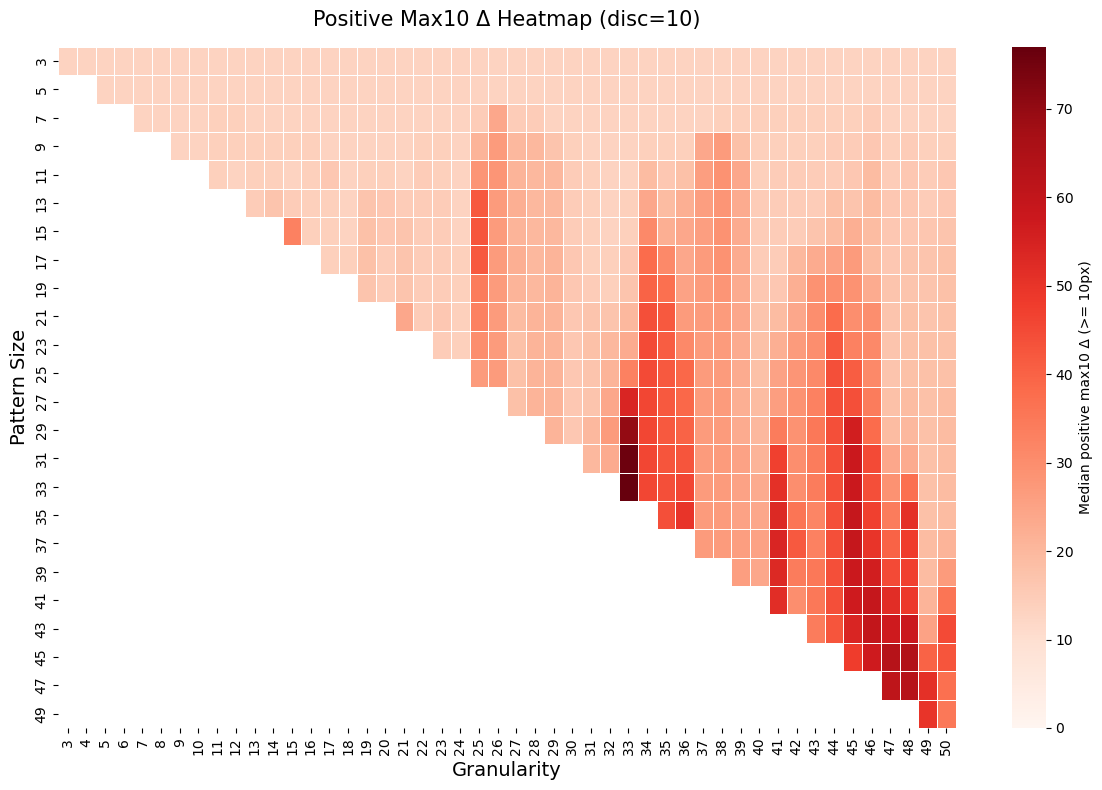

Rows used: 4,510,801
Range: 13.000 to 77.000


In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

DISC_SEL = 10
BASE_FS = 14

d = df_pos[df_pos["discrepency"] == DISC_SEL].copy()
d = d[d["granularity_int"].astype(int) % 2 == 1]  # odd granularities only for visual

if d.empty:
    print(f"No positive-delta rows for disc={DISC_SEL}")
else:
    gran_order = sorted(d["granularity_int"].drop_duplicates().astype(int).tolist())
    freq_order = sorted(d["frequency"].drop_duplicates().tolist())

    hm = d.pivot_table(
        index="granularity_int",
        columns="frequency",
        values="pos_max10_delta",
        aggfunc="median"
    ).reindex(index=gran_order, columns=freq_order)  

    fig, ax = plt.subplots(figsize=(12, 8))
    vmax = np.nanmax(hm.values) if np.isfinite(hm.values).any() else 1.0

    sns.heatmap(
        hm, ax=ax, cmap="Reds",
        vmin=0, vmax=vmax,
        annot=False, linewidths=0.5,
        cbar_kws={"label": f"Median positive max10 Δ (>= {MIN_PX_AT_OR_ABOVE}px)"},
    )

    ax.set_title(f"Positive Max10 Δ Heatmap (disc={DISC_SEL})", fontsize=BASE_FS+1, pad=15)
    ax.set_xlabel("Granularity", fontsize=BASE_FS)
    ax.set_ylabel("Pattern Size", fontsize=BASE_FS)
    ax.set_yticklabels([str(int(x)) for x in hm.index])

    plt.tight_layout()
    plt.show()

    print(f"Rows used: {len(d):,}")
    print(f"Range: {np.nanmin(hm.values):.3f} to {np.nanmax(hm.values):.3f}")